<h1> Research Project: Timing Variables

In [48]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import DateOffset

<h2> 1. Data

S&P500 Historical Constituents

In [40]:
path = r"C:\Users\tyyew\Desktop\Quant\Python\Data\components.csv"
index = pd.read_csv(path)

# create list of historical S&P500 constituents
index_set = set()
for row in index['tickers']:
    list_ = row.split(',')
    index_set.update(list_)
    
string = " ".join(index_set)
text_file = open(r"S&P500.txt", "w")
text_file.write(string)
text_file.close()

In [39]:
# create one-hot table


<h2> 2. Methodology

<h2> 3. Implementation

<h3> Timing Variables and Factor Returns

In [292]:
path2 = r"C:\Users\tyyew\Desktop\Quant\Columbia MAFN\Study Materials\Sem 3\Quantitative Methods in Investment Management\Project\Timing Variables.xlsx"
timing_variables = pd.read_excel(path2,sheet_name = "Timing Variables", index_col = 0).fillna(0)
factor_returns = pd.read_excel(path2,sheet_name = "Factor Returns", index_col = 0, usecols = ['Date', 'Value', "Momentum"])

In [170]:
# whole period
start_date0 = pd.Timestamp('1989-12-31')
start_date = start_date0 + DateOffset(months=1)
end_date0 = pd.Timestamp('2022-01-31')
end_date = end_date0 + DateOffset(months=1)
# training period
train_start_date0 = pd.Timestamp('1989-12-31')
train_start_date = train_start_date0 + DateOffset(months=1)
train_end_date0 = pd.Timestamp('1999-12-31')
train_end_date = train_end_date0 + DateOffset(months=1)
# testing period
test_start_date0 = pd.Timestamp('2000-01-31')
test_start_date = test_start_date0 + DateOffset(months=1)
test_end_date0 = pd.Timestamp('2022-01-31')
test_end_date = test_end_date0 + DateOffset(months=1)

<function matplotlib.pyplot.show(close=None, block=None)>

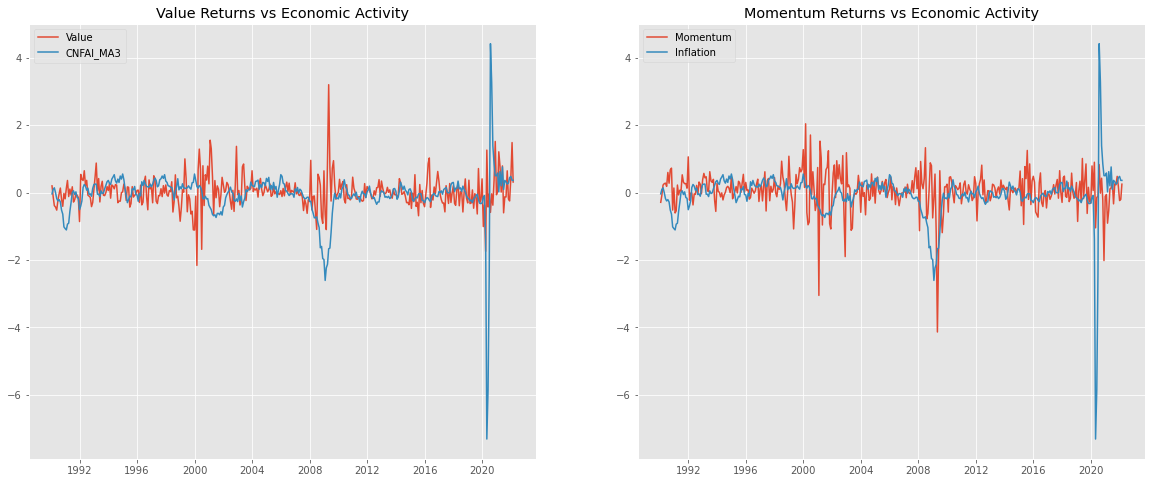

In [333]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))

ax1.plot(factor_returns.loc[start_date:end_date, 'Value'] * 12, label = 'Value')
ax1.plot(timing_variables.loc[start_date:end_date, 'CNFAI_MA3'], label = 'CNFAI_MA3')
ax1.set_title('Value Returns vs Economic Activity')
ax1.legend()

ax2.plot(factor_returns.loc[start_date:end_date, 'Momentum'] * 12, label = 'Momentum')
# ax21 = ax2.twinx()
ax2.plot(timing_variables.loc[start_date:end_date, 'CNFAI_MA3'],  label = 'Inflation')
ax2.set_title('Momentum Returns vs Economic Activity')
ax2.legend()

plt.show

In [265]:
def run_ols(predictor, factor, start_date, end_date):
    start_date1 = start_date + DateOffset(months=1)
    end_date1 = end_date + DateOffset(months=1)
    x = timing_variables.loc[start_date:end_date, predictor] 
    # x_norm = (x - x.mean())/x.std()
    X_train = np.array(x).reshape(-1,1)
    y_train = np.array(factor_returns.loc[start_date1:end_date1, factor])
    reg = LinearRegression().fit(X_train,y_train)
    
    r2 = reg.score(X_train,y_train)
    beta0 = reg.intercept_
    beta1 = reg.coef_
    
    
    return r2, beta0, beta1

In [266]:
# model fit
r2, beta0, beta1 = run_ols('Inflation', 'Momentum', train_start_date0, train_end_date0)

In [283]:
mom_inflation = pd.DataFrame(columns = ['Forecasted Returns', 'Actual Returns'])
mom_inflation['Actual Returns'] = factor_returns.loc[test_start_date:test_end_date, 'Momentum']
temp = timing_variables.loc[test_start_date0:test_end_date0, 'Inflation'] * beta1 + beta0
mom_inflation['Forecasted Returns'] = temp.shift(1, freq  = 'infer')
mom_inflation['Signal1'] = mom_inflation['Forecasted Returns'].pct_change().fillna(0)
mom_inflation['Gamma'] = 1/(1 + np.exp(-mom_inflation['Signal1']))
mom_inflation

,Forecasted Returns,Actual Returns,Signal1,Gamma
Date,,,,
2000-02-29,0.012069,0.170110,0.000000,0.500000
2000-03-31,0.012878,-0.049388,0.067054,0.516757
2000-04-30,0.014084,-0.079772,0.093661,0.523398
2000-05-31,0.009621,-0.072787,-0.316903,0.421431
2000-06-30,0.011236,0.142343,0.167875,0.541870
...,...,...,...,...
2021-10-31,0.012860,0.040026,0.043252,0.510811
2021-11-30,0.016004,0.015547,0.244520,0.560827
2021-12-31,0.014850,-0.019884,-0.072121,0.481978


<h3> Benchmark

In [298]:
factor_returns_test = factor_returns.loc[test_start_date:test_end_date].copy()
# naive benchmark
factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum'])
# static 60-40 
factor_returns_test['ValMom-60-40'] = 0.6 * factor_returns_test['Value'] + 0.4 * factor_returns_test['Momentum']
# static 40-60
factor_returns_test['ValMom-40-60'] = 0.4 * factor_returns_test['Value'] + 0.6 * factor_returns_test['Momentum']
# dynamic
factor_returns_test['ValMom-gamma']  = factor_returns_test['Value'] * (1 - mom_inflation['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation['Gamma'])

In [299]:
# compute performance measures
ret_annualized = np.mean(factor_returns_test.loc[start_date:end_date]) * 12
vol_annualized = np.std(factor_returns_test.loc[start_date:end_date]) * 12
sharpe = np.mean(factor_returns_test.loc[start_date:end_date])/ np.std(factor_returns_test.loc[start_date:end_date])
# turnover = 
# drawdown = 
# transaction_cost = 
# information_ratio = 
summary = pd.DataFrame(columns = ['Return', 'Volatility', 'SharpeRatio'])
summary['Return'] = ret_annualized
summary['Volatility'] = vol_annualized
summary['SharpeRatio'] = sharpe
summary.T

,Value,Momentum,ValMom-50-50,ValMom-60-40,ValMom-40-60,ValMom-gamma
Return,0.038242,0.027217,0.032729,0.033832,0.031627,0.041001
Volatility,0.511266,0.627434,0.213937,0.209312,0.265080,0.219066
SharpeRatio,0.074799,0.043378,0.152986,0.161634,0.119311,0.187165


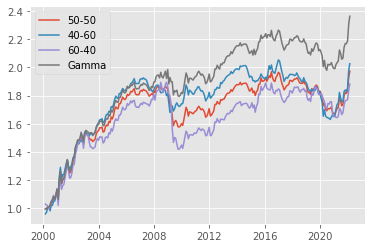

In [303]:
# cumulative returns
plt.plot(np.cumprod(1 + factor_returns_test['ValMom-50-50']), label = '50-50')
plt.plot(np.cumprod(1 + factor_returns_test['ValMom-60-40']), label = '40-60')
plt.plot(np.cumprod(1 + factor_returns_test['ValMom-40-60']), label = '60-40')
plt.plot(np.cumprod(1 + factor_returns_test['ValMom-gamma']), label = 'Gamma')
plt.legend()

<h2> 4. Appendix

<h3> Gamma

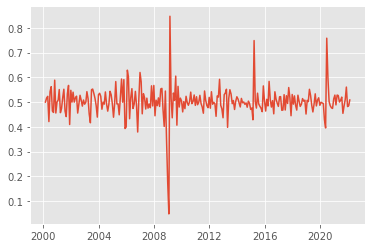

In [304]:
plt.plot(mom_inflation['Gamma'])